## Прогнозирование оттока клиентов телекоммуникационной компании

### Исходные данные:


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

#### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Цель:

Построить модели определения абонентов с высокой верояностью оттока. Выбрать лучшую модель по метрике ROCAUC

### План работы:

    1. Знакомство с данными
        1.1 Проверка данных на адекватность, а также наличие пропусков, дублей.
        1.2 Получение целевого признака. Анализ баланса классов.
        1.3 Исследовательский анализ данных, преобразование типов, добавление признаков.
        
    2. Подготовка данных
        2.1 Объединение таблиц.
        2.2 Проверка степени влияния признаков на целевой признак и оптимизация датасета
        2.3 Выделение тестовой выборки.
        2.4 Кодирование категориальных признаков
        2.5 Стандартизация
        2.6 Устранение дисбаланса классов
        2.7 Разделение датасета на признаки (features) и целевой признак (target)
        
    3. Обучение моделей на подготовленных данных.
        3.1 Логистическая регрессия
        3.2 Случайный лес
        3.3 Catboost
        3.4 LGBM
        
    4. Тестирование моделей. Выбор лучшей модели на основании значений метрики ROC-AUC(дополнительная метрика - accuracy) на тестовой выборке.
    
    5. Выводы
    

### Знакомство с данными

In [2]:
# импорт Pandas
import pandas as pd

# импорт Os для работы с файлами и каталогами
import os

# импорт Numpy
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt

import seaborn as sns

# импорт Sklearn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

# импорт Catboost

from catboost import CatBoostClassifier

# импорт LightGBM

from lightgbm import LGBMClassifier

pd.options.display.float_format = '{:,.3f}'.format

In [3]:
# напишем функцию для комфортной загрузки датасетов и локально, и с сервера

def file_loader(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Check the path')

In [4]:
personal = file_loader('personal.csv', '/datasets/final_provider/personal.csv')
contract = file_loader('contract.csv', '/datasets/final_provider/contract.csv')
internet = file_loader('internet.csv', '/datasets/final_provider/internet.csv')
phone = file_loader('phone.csv', '/datasets/final_provider/phone.csv')

In [5]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


В данной таблице видим персональные данные абонентов.

In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [8]:
personal[['SeniorCitizen', 'Partner', 'Dependents']].value_counts()

SeniorCitizen  Partner  Dependents
0              No       No            2719
               Yes      Yes           1666
                        No            1163
1              No       No             561
               Yes      No             490
0              No       Yes            353
1              Yes      Yes             83
               No       Yes              8
dtype: int64

In [9]:
personal['customerID'].duplicated().sum()

0

#### Вывод:
Данные в хорошем состоянии: пропусков - нет, дубликатов - тоже нет, все столбцы имеют бинарные категориальные признаки, которые легко будет закодировать цифрами. Таблица практически не нуждается в обработке.

In [10]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.200,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.400,306.6


Таблица с данными по контрактам. Здесь мы видим возможность получить целевой признак из столбца *EndDate*: если дата окончания контракта есть, то это ушедшие абоненты, которых нам и надо спрогнозировать и они получать целевой признак 1, остальные (без даты окончания контракта) - получат признак 0. Добавим соотвествующий столбец.

In [11]:
contract['IsChurn'] = contract['EndDate']
contract.loc[contract['IsChurn'] == 'No', 'IsChurn'] = 0
contract.loc[contract['IsChurn'] != 0, 'IsChurn'] = 1
contract['IsChurn'] = contract['IsChurn'].astype('int64')
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800,1990.5,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.200,7362.9,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.400,306.6,1


Раз уж получили целевой признак, посмотрим сразу на баланс классов

In [12]:
contract['IsChurn'].value_counts(1)

0   0.735
1   0.265
Name: IsChurn, dtype: float64

Дисбаланс был ожидаем, поскольку в здоровой компании доля потерянных абонентов не может быть 50% (если конечно это не ее предсмертный момент)) Будем с ним работать на следующих этапах. Учитывая довольно небольшую выборку, с большой долей вероятности можно сказать, что это будет upsampling. Этот метод помимо устранения дисбаланса поможет увеличить количество обучающих элементов для наших моделей.

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   IsChurn           7043 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


На первый взгляд кажется, что и тут данные в порядке, пропусков нет. Но смущает неподходящий тип данных в графе "TotalCharges". Исследуем эту графу повнимательнее.

In [14]:
contract['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
5435        1
1051.05     1
451.1       1
248.95      1
892.15      1
Name: TotalCharges, Length: 6531, dtype: int64

Так и есть. У 11 абонентов в этой графе пропуск, который почему-то вместо NaN отметился пробелом. Эти пропуски восстановим используя данные о среднемесячных списаниях и сроке пользования абонентами услугами.

In [15]:
contract['MonthlyCharges'].describe()

count   7,043.000
mean       64.762
std        30.090
min        18.250
25%        35.500
50%        70.350
75%        89.850
max       118.750
Name: MonthlyCharges, dtype: float64

<AxesSubplot:>

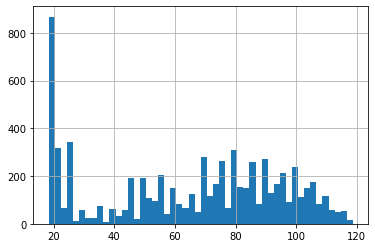

In [16]:
contract['MonthlyCharges'].hist(bins=50)

В начале распределения видим большой пик в котором и рядом с которым "собрались" абоненты, "сидящие" на минимальных тарифах. Скорее всего, это просто абонентская плата. Данные пики аномалией не являются. 

In [17]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')
contract['BeginDate'].describe()

<ipython-input-17-150822add97f>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  contract['BeginDate'].describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

В колонке *BeginDate* мы видим только первые числа месяцев, что говорит нам о том, что минимальным периодом, который можно рассматривать, в данном случае является месяц. <br>

Выборка включает контракты, которые были заключены с октября 2013г. по февраль 2020, т.е. 6 лет и 5 мес. Период выглядит адекватным. <br>

Сами месяца заключения контрактов вряд ли окажут влияние на поведение абонентов, а вот период действия контракта может быть связать с оттоком. Поэтому правильнее будет в итоговый датасет включить не колонку *BeginDate*, а новую колонку со периодом *ContractPeriod* . 

In [18]:
# заменим значение "No" в столбце 'EndDate' на конечную дату (точнее месяц) датасета

contract['EndPeriod'] = contract['EndDate'].replace('No', '2020-02-01 00:00:00').astype('datetime64')
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,EndPeriod
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,0,2020-02-01
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,0,2020-02-01
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,1,2019-12-01
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,0,2020-02-01
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,1,2019-11-01
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800,1990.5,0,2020-02-01
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.200,7362.9,0,2020-02-01
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600,346.45,0,2020-02-01
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.400,306.6,1,2019-11-01


In [19]:
contract['ContractPeriod'] = (contract['EndPeriod'] - contract['BeginDate']).astype('timedelta64[M]').astype('int64') + 1
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,EndPeriod,ContractPeriod
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,0,2020-02-01,2
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,0,2020-02-01,35
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,1,2019-12-01,3
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,0,2020-02-01,46
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,1,2019-11-01,3
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800,1990.5,0,2020-02-01,24
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.200,7362.9,0,2020-02-01,72
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600,346.45,0,2020-02-01,12
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.400,306.6,1,2019-11-01,5


Получили новый важный признак - количество месяцев действия контракта.

Теперь можем разобраться с пропусками в столбце 'TotalCharges'

In [20]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract.loc[contract['TotalCharges'] == ' ', 'MonthlyCharges'] \
* contract.loc[contract['TotalCharges'] == ' ', 'ContractPeriod']
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   IsChurn           7043 non-null   int64         
 9   EndPeriod         7043 non-null   datetime64[ns]
 10  ContractPeriod    7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 605.4+ KB


In [21]:
contract['TotalCharges'].describe()

count   7,043.000
mean    2,279.799
std     2,266.730
min        18.800
25%       398.550
50%     1,394.550
75%     3,786.600
max     8,684.800
Name: TotalCharges, dtype: float64

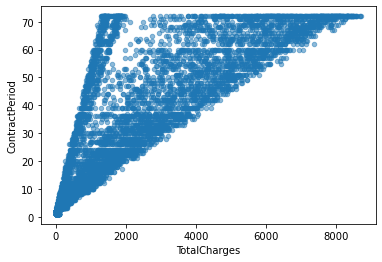

In [22]:
contract.plot('TotalCharges', 'ContractPeriod', kind='scatter', alpha=0.5);

На графике видим четкую корреляцию периода действия контракта с доходом от абонента. Данные в столбце 'TotalCharges' адекватны.

In [23]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Значения в столбце в порядке. Этот столбец может оказаться важным по влиянию на целевой признак.

In [24]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Наличие бумажных счетов или их отсутствие вряд ли повлияет на отток абонентов, поэтому этот столбец скорее всего удалим.

In [25]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Вид платежа сам по себе также скорее всего не влияет на целевой признак, а вот автоматические или ручные платежи - это скорее всего существенный фактор для привязанности абонента. Скорее всего, отток абонентов с автоматической оплатой будет ниже.

In [26]:
contract.pivot_table(columns='IsChurn', index='PaymentMethod', values='customerID', aggfunc='count', margins=True)

IsChurn,0,1,All
PaymentMethod,,,
Bank transfer (automatic),1286,258,1544
Credit card (automatic),1290,232,1522
Electronic check,1294,1071,2365
Mailed check,1304,308,1612
All,5174,1869,7043


Сводная таблица выше частично подтверждает нашу гипотезу. Однако, из нее видно, что больше половины потерянных абонентов сосредоточена в одной категории 'Electronic check'. Возможно в данной колонке стоит сохранить все категориальные признаки для обучения нашей модели.

In [27]:
contract['customerID'].duplicated().sum()

0

Дубликатов - нет.

#### Вывод:

За исключением небольшого количества пропусков - данные также в хорошем состоянии. <br>
В данном датасете выделили целевой признак, а также дополнили датасет важным признаком - период контракта, который выражен в количестве месяцев. <br> 
Кроме того, определили другие ключевые признаки для дальнейшей работы.

In [28]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Первом делом, в данной таблице бросается в глаза меньшее количество абонентов. Это может быть нормальным, если допустить, что часть клиентов пользуется только одним видом услуг, например, только интернетом или только телефоном.

In [29]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет. Все колонки категориальные.

In [30]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

В данной колонке видим 2 вида технологии подключения. По логике данный признак может существенно влиять на отток, поскольку абоненты часто переходят на новую, продвинутую технологию, которую в том числе могут предложить и конкуренты.

In [31]:
internet[internet == 'Yes'].count()

customerID             0
InternetService        0
OnlineSecurity      2019
OnlineBackup        2429
DeviceProtection    2422
TechSupport         2044
StreamingTV         2707
StreamingMovies     2732
dtype: int64

In [32]:
for elem in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    col = internet[elem].value_counts()
    print(col)
   

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
No     3473
Yes    2044
Name: TechSupport, dtype: int64
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


Значения в данных столбцах все бинарные. Возможно, что на отток больше влияет не наличие какой-то конкретной доп. услуги, а общее количество доп. услуг. Проверим эту гипотезу после объединения таблиц. А пока добавим в таблицу признак с количеством доп. услуг.

In [33]:
internet['services_count'] = internet[internet[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes'].count(axis=1)


In [34]:
internet['services_count'].value_counts()

3    1118
2    1033
1     966
4     852
0     693
5     571
6     284
Name: services_count, dtype: int64

In [35]:
internet['customerID'].duplicated().sum()

0

Дубликатов - нет.

#### Вывод:

Данные в датасете в хорошем состоянии.<br>
Добавили новый признак с количеством доп. услуг.<br>
При слиянии таблиц нужно будет учитывать, что в этом датафрейте меньше строк, чем в двух предыдущих. А это значит могут появиться пропуски...

In [36]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


В последнем датасете мы видим самую маленькую таблицу, дающую нам 2 признака:
1) - это наличие услуги телефонии в принципе
2) - это является ли подключенная телефония многоканальной.

Оба признака важны, т.к. могут влиять на отток абонентов (скорее на удержание, но это две стороны одной медали)

In [37]:
phone['customerID'].duplicated().sum()

0

#### Вывод:

Данные в датасете в хорошем состоянии.<br>
Необходимо учитывать, что само нахождение *customer_id* ы данном датасете говорит о наличии у абонентов услуги телефонии.<br>
При слиянии таблиц нужно будет учитывать, что в этом датафрейте меньше строк, чем в двух предыдущих. А это значит могут появиться пропуски...

### Вывод:
1. Датасет для обучения модели относительно небольшой -всего 7043 наблюдений.
2. Данные большей частью адекватны нашим задачам, пропусков почти нет, дубликатов вообще нет. 
3. Требуется объединение первичных таблиц, проверка степени влияния признаков на целевой признак и принятие решений по итоговому набору столбцов датасета для дальнейших этапов.
4. Целевой признак выделен во второй таблице - *contract*. Обнаружен существенный дисбаланс классов. Учитывая небольшой размер датасета оптимальным методом работы с дисбалансом классов видится upsampling

### Подготовка данных

#### Объединение таблиц

In [38]:
full_data = personal.merge(contract, on='customerID')
full_data = full_data.merge(internet, on='customerID', how='left')
full_data = full_data.merge(phone, on='customerID', how='left')
full_data.head(30)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,ContractPeriod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,2,DSL,No,Yes,No,No,No,No,1.000,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,35,DSL,Yes,No,Yes,No,No,No,2.000,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,3,DSL,Yes,Yes,No,No,No,No,2.000,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,46,DSL,Yes,No,Yes,Yes,No,No,3.000,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,3,Fiber optic,No,No,No,No,No,No,0.000,No
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,9,Fiber optic,No,No,Yes,No,Yes,Yes,3.000,Yes
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),...,23,Fiber optic,No,Yes,No,No,Yes,No,2.000,Yes
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,...,11,DSL,Yes,No,No,No,No,No,1.000,NaN
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,29,Fiber optic,No,No,Yes,Yes,Yes,Yes,4.000,Yes
9,6388-TABGU,Male,0,No,Yes,2014-12-01,No,One year,No,Bank transfer (automatic),...,63,DSL,Yes,Yes,No,No,No,No,2.000,No


In [39]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  IsChurn           7043 non-null   int64         
 13  EndPeriod         7043 non-null   datetime64[ns]
 14  ContractPeriod    7043 n

После слияния таблиц мы видим пропуски у тех абонентов, которые не пользовались соответствующими услугами. Кроме того, в итоговой таблице нет явного признака, показывающего какими основными услугами пользуется абонент (интернет, телефония, или и то, и другое). Разберемся с этими проблемами:

In [40]:
def get_basic_service(row):
    if row['InternetService'] in ['Fiber optic', 'DSL']:
        if row['MultipleLines'] in ['Yes', 'No']:
            return 'both'
        return 'internet'
    else:
        return 'phone'

In [41]:
full_data['basic_service'] = full_data.apply(get_basic_service, axis=1)
full_data['basic_service'].value_counts()

both        4835
phone       1526
internet     682
Name: basic_service, dtype: int64

Все пропуски заполним значением "No" поскольку оно точно отражает суть.

In [42]:
full_data = full_data.fillna('Other')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  IsChurn           7043 non-null   int64         
 13  EndPeriod         7043 non-null   datetime64[ns]
 14  ContractPeriod    7043 n

In [43]:
full_data.head(30)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines,basic_service
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,1.000,Other,internet
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,2.000,No,both
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,2.000,No,both
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,3.000,Other,internet
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,No,No,No,No,0.000,No,both
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,Yes,No,Yes,Yes,3.000,Yes,both
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),...,Fiber optic,No,Yes,No,No,Yes,No,2.000,Yes,both
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,...,DSL,Yes,No,No,No,No,No,1.000,Other,internet
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,4.000,Yes,both
9,6388-TABGU,Male,0,No,Yes,2014-12-01,No,One year,No,Bank transfer (automatic),...,DSL,Yes,Yes,No,No,No,No,2.000,No,both


#### Вывод:

Получена консолидированная таблица с полным набором признаков. Можно приступать к оценки полезности этих признаков

#### Проверка степени влияния признаков на целевой признак и оптимизация датасета

Проверим сначала на степень влияния на целевой признак категориальные признаки нашего объединенного датасета. Для этого сохраним в переменной список всех этих столбцов

In [44]:
cat_columns = list(full_data.select_dtypes(include=['object']).columns)
cat_columns

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'services_count',
 'MultipleLines',
 'basic_service']

In [45]:
cat_columns.pop(0)
cat_columns.pop(3)

'EndDate'

In [46]:
cat_columns.append('SeniorCitizen')
cat_columns

['gender',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'services_count',
 'MultipleLines',
 'basic_service',
 'SeniorCitizen']

In [47]:
for col in cat_columns:
    print(full_data.groupby(col)['IsChurn'].agg(['count', 'sum', 'mean']))
    print('------------------------------------')

        count  sum  mean
gender                  
Female   3488  939 0.269
Male     3555  930 0.262
------------------------------------
         count   sum  mean
Partner                   
No        3641  1200 0.330
Yes       3402   669 0.197
------------------------------------
            count   sum  mean
Dependents                   
No           4933  1543 0.313
Yes          2110   326 0.155
------------------------------------
                count   sum  mean
Type                             
Month-to-month   3875  1655 0.427
One year         1473   166 0.113
Two year         1695    48 0.028
------------------------------------
                  count   sum  mean
PaperlessBilling                   
No                 2872   469 0.163
Yes                4171  1400 0.336
------------------------------------
                           count   sum  mean
PaymentMethod                               
Bank transfer (automatic)   1544   258 0.167
Credit card (automatic)     1522   232

Из полученного анализа делаем следующие выводы:
 1. Пол абонента практически не влияет на отток, но все же небольшая разница есть.
 
 2. Признак *Partner*, который коллеги, готовившие описание, почему-то определили как наличие супруга(и) (мне кажется этот столбец имеет другое значение, например, статус "ключевого абонента") существенно снижает отток.
 
 3. То же самое можно сказать про признак наличия иждивенцев.
 
 4. Тип контракта существенно влияет на отток. Мы видим, что 43% контрактов типа *Month-to-month* были прекращены, зато доля закрывшихся двухгодичных контрактов всего 3%. Важный признак!
 
 5. А вот отказ от бумажных счетов неожиданно повышает вероятность закрытия контракта!
 
 6. Из способов оплаты сильно выделяется электронная оплата - среди этих абонентов ушло 45%, хотя в остальных видах оплаты всего 15 - 19%
 
 7. Также оказалось, что 42% пенсионеров отказалось от услуг, а из остальных пользователей всего 24%. Скорее всего, кто-то из конкурентов активно заманивает эту целевую аудиторию.
 
 8. Что касается пользования основными услугами, то чаще уходят пользователи обоих услуг - 33% и реже всего пользователи только телефонии - всего 7%.
 
 9. Что касается дополнительных услуг интернет, то их количество снижает вероятность оттока. Так уходят:
      * 52% пользователей услуг интернет без доп. услуг, 
      * 27% пользователей услуг интернет с тремя услугами,
      * 7% пользователей услуг интернет с шестью услугами.
      Степень влияния на отток каждой услуги также различна.
 10. 42% пользователей оптоволоконной технологии закрыли контракт, в DSL - только 19%
 11. Наличие многоканальной телефонной линии немного повышает вероятность ухода абонента, что не совсем логично. Возможно это просто случайность.

Теперь посмотрим корреляцию с целевым признаком числовых данных: непрерывных (MonthlyCharges, TotalCharges) и дискретных (ContractPeriod).

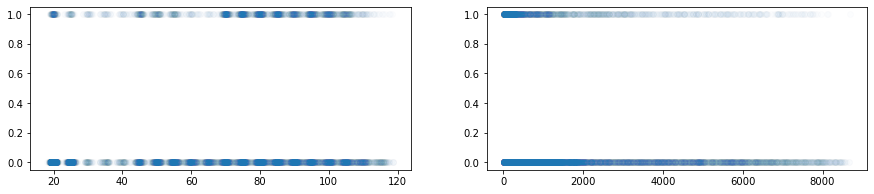

In [48]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.scatter(full_data['MonthlyCharges'], full_data['IsChurn'], alpha=0.01)
plt.subplot(1, 2, 2)
plt.scatter(full_data['TotalCharges'], full_data['IsChurn'], alpha=0.01);

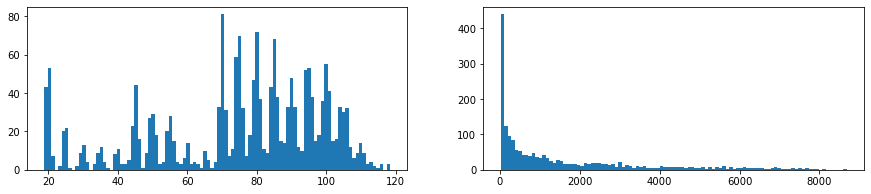

In [49]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.hist(full_data[full_data['IsChurn'] == 1]['MonthlyCharges'], bins=100)
plt.subplot(1, 2, 2)
plt.hist(full_data[full_data['IsChurn'] == 1]['TotalCharges'], bins=100);

In [50]:
full_data['IsChurn'].corr(full_data['MonthlyCharges'])

0.19335642223784705

In [51]:
full_data['IsChurn'].corr(full_data['TotalCharges'])

-0.19834704174611756

Из исследования видно:

1. Ежемесячный средний чек показывает небольшую положительную корреляцию с вероятностью оттока. Зависимость нечеткая, но на графиках можно выявить несколько большую плотность закрытых контрактов в диапазоне от 70 до 100 ед. валюты в мес. 

2. Общий доход от абонента показывает отрицательную корреляцию с целевым признаком. Из графиков видно, что уходят в основном те, кто в целом потратил мало денег. Может просто не успел? Посмотрим какая ситуации в зависимости от длительности контракта.

Корреляция слишком мала, связь может быть случайной

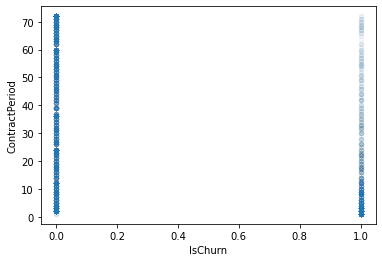

In [52]:
full_data.plot('IsChurn', 'ContractPeriod', kind='scatter', alpha=0.01);

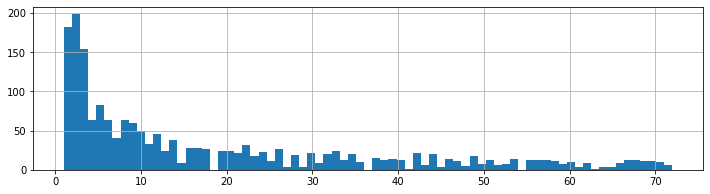

In [53]:
full_data[full_data['IsChurn'] == 1]['ContractPeriod'].hist(bins=75, figsize=(12, 3));

In [54]:
full_data['IsChurn'].corr(full_data['ContractPeriod'])

-0.35723185249687783

Из графиков видно, что существенная доля абонентов расторгает контракт в первые 3 мес. пользования услугами, а спустя год вероятность оттока уже сильно падает. Видимо часть "свежих" абонентов, что-то не устраивает в сервисе либо качестве услуг и спустя пробный период они уходят.

Посмотрим на тепловую карту корелляции количественных признаков между собой.

<AxesSubplot:>

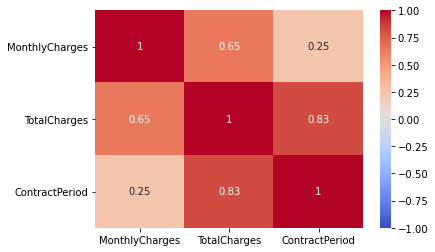

In [55]:
sns.heatmap(full_data[['MonthlyCharges', 'TotalCharges', 'ContractPeriod']].corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Из диаграммы видим, что между средним чеком и общими доходами от абонента довольно большая корреляция, а между общими доходами от абонента и периодом контрактов корреляция еще больше. Это и понятно, значения в графе 'TotalCharges' по сути произведение колонки 'MonthlyCharges' на 'ContractPeriod'.<br>
Такая зависимость между независимыми признаками называется мультиколлинеарностью и может быть вредна для линейных моделей.

Удалим из нашего датасета все столбцы, которые мы посчитали неэффективными для установления зависимостей тестируемых моделей + столбец с датами и идентификационным номером абонентов.

In [56]:
good_data = full_data.drop(['customerID', 'BeginDate', 'EndDate', 'EndPeriod', 'TotalCharges'], axis=1)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   IsChurn           7043 non-null   int64  
 9   ContractPeriod    7043 non-null   int64  
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


#### Вывод:

В результате исследования зависимости целевого признака от признаков в датасете были установлены разные степени влияния этих признаков на отток:

1. Загадочная колонка *Partner*, наличие иждевенцев, наличие длительных типов контрактов, длительность контракта, наличие доп. услуг при пользовании интернетом, сами эти услуги в разной степени - снижают вероятность оттока клиента.

2. Пенсионный возраст, отказ от бумажных счетов, в некоторой степени среднемесячный чек повышают вероятность ухода абонента.

3. Отток больше у пользователей сразу двумя услугами - 33%, у пользователей только услугой интернет - 25%, а телефонией - всего 7%. На услуге интернет отток больше с оптоволоконных линий, чем с DSL.

Таким образом мы выделили наиболее значимые признаки и оставили их в наборе данных для дальнейшей работы. Из датасета были удалены след столбцы:

<br>
  'customerID', 'BeginDate', 'EndDate', 'EndPeriod' - как не несущие никакого смысла для обучения модели<br>  

#### Разделение выборки

In [57]:
features = good_data.drop('IsChurn', axis=1)
target = good_data['IsChurn']

In [58]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=120922)


In [59]:
train_target.value_counts(1), test_target.value_counts(1)

(0   0.735
 1   0.265
 Name: IsChurn, dtype: float64,
 0   0.734
 1   0.266
 Name: IsChurn, dtype: float64)

In [60]:
train_features


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,ContractPeriod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines,basic_service
1827,Female,0,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),50.900,46,DSL,Yes,No,No,No,Yes,Yes,3.000,Other,internet
3836,Female,0,Yes,No,One year,No,Bank transfer (automatic),58.350,65,DSL,No,No,Yes,Yes,No,No,2.000,Yes,both
6893,Female,0,Yes,Yes,Month-to-month,No,Credit card (automatic),55.900,7,DSL,Yes,Yes,No,No,No,No,2.000,No,both
5930,Female,0,No,No,Two year,Yes,Bank transfer (automatic),84.700,72,Fiber optic,Yes,No,No,Yes,No,No,2.000,Yes,both
4592,Female,0,Yes,Yes,One year,Yes,Mailed check,24.200,39,Other,Other,Other,Other,Other,Other,Other,Other,Yes,phone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,Male,1,No,No,Month-to-month,Yes,Electronic check,43.650,12,DSL,No,No,Yes,Yes,No,Yes,3.000,Other,internet
5233,Female,0,Yes,No,Month-to-month,No,Electronic check,101.150,9,Fiber optic,No,Yes,Yes,No,Yes,Yes,4.000,No,both
1466,Male,0,Yes,Yes,Month-to-month,Yes,Electronic check,49.200,12,DSL,Yes,No,No,No,No,No,1.000,No,both
1854,Male,1,No,No,Month-to-month,Yes,Electronic check,43.300,1,DSL,No,Yes,Yes,No,No,Yes,3.000,Other,internet


#### Вывод:

Выборка разделена на обучающую и тестовую в соотношении 3:1.

#### Кодирование категориальных признаков

Поскольку у нас есть часть признаков с числом категорий больше 2, то оптимальным способом кодирования будет Ординарное кодирование.

In [61]:
train_features = train_features.replace('Other', 'No')
test_features = test_features.replace('Other', 'No')

In [62]:
cat_columns = train_features.select_dtypes(include=['object']).columns
cat_columns = cat_columns.drop('services_count')
    
enc = OrdinalEncoder(dtype='int64')
enc.fit(train_features[cat_columns])
train_features[cat_columns] = enc.transform(train_features[cat_columns])    

In [63]:
test_features[cat_columns] = enc.transform(test_features[cat_columns]) 

In [64]:
train_features = train_features.replace('No', 10)
train_features['services_count'] = train_features['services_count'].astype('int64')
test_features = test_features.replace('No', 10)
test_features['services_count'] = test_features['services_count'].astype('int64')

In [67]:
train_features

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,ContractPeriod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines,basic_service
1827,0,0,1,1,0,1,0,50.900,46,0,1,0,0,0,1,1,3,0,1
3836,0,0,1,0,1,0,0,58.350,65,0,0,0,1,1,0,0,2,1,0
6893,0,0,1,1,0,0,1,55.900,7,0,1,1,0,0,0,0,2,0,0
5930,0,0,0,0,2,1,0,84.700,72,1,1,0,0,1,0,0,2,1,0
4592,0,0,1,1,1,1,3,24.200,39,2,0,0,0,0,0,0,10,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1,1,0,0,0,1,2,43.650,12,0,0,0,1,1,0,1,3,0,1
5233,0,0,1,0,0,0,2,101.150,9,1,0,1,1,0,1,1,4,0,0
1466,1,0,1,1,0,1,2,49.200,12,0,1,0,0,0,0,0,1,0,0
1854,1,1,0,0,0,1,2,43.300,1,0,0,1,1,0,0,1,3,0,1


In [65]:
test_features

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,ContractPeriod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines,basic_service
5114,0,1,0,0,0,1,2,83.400,51,1,1,1,0,0,0,0,2,1,0
4804,0,0,0,0,1,1,2,118.600,62,1,1,1,1,1,1,1,6,1,0
1875,1,0,1,0,2,1,1,114.100,72,1,1,1,1,1,1,1,6,1,0
3685,1,0,1,0,1,1,0,44.450,51,0,1,0,0,1,1,0,3,0,1
543,1,0,0,0,0,1,0,86.050,10,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,0,0,0,1,0,0,3,24.000,2,2,0,0,0,0,0,0,10,1,2
3578,0,0,0,0,0,0,3,65.100,41,0,1,1,0,0,1,0,3,0,0
3506,1,0,0,0,0,1,2,84.750,20,1,1,0,1,0,0,0,2,1,0
460,1,0,0,1,0,0,3,19.650,7,2,0,0,0,0,0,0,10,0,2


In [66]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1827 to 6040
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5282 non-null   int64  
 1   SeniorCitizen     5282 non-null   int64  
 2   Partner           5282 non-null   int64  
 3   Dependents        5282 non-null   int64  
 4   Type              5282 non-null   int64  
 5   PaperlessBilling  5282 non-null   int64  
 6   PaymentMethod     5282 non-null   int64  
 7   MonthlyCharges    5282 non-null   float64
 8   ContractPeriod    5282 non-null   int64  
 9   InternetService   5282 non-null   int64  
 10  OnlineSecurity    5282 non-null   int64  
 11  OnlineBackup      5282 non-null   int64  
 12  DeviceProtection  5282 non-null   int64  
 13  TechSupport       5282 non-null   int64  
 14  StreamingTV       5282 non-null   int64  
 15  StreamingMovies   5282 non-null   int64  
 16  services_count    5282 non-null   int64

#### Вывод:

Все категориальные признаки перекодированы в цифровой вид, это позволит нам использовать их в обучении разных моделей, в том числе и тех, которые не умеют работать с обычныеми категориальными признаками.

**Стандартизация**

Осталось разобраться с непрерывными числовыми столбцами. Для того, чтобы модель не считала эти столбцы более важными из-за наличия больших значений проведем стандартизацию этих столбцов, т.е. перекодируем значения таким образом, чтобы среднее их было равно 0, а стандартное отклонение 1

In [487]:
numeric = ['MonthlyCharges']

In [488]:
scaler = StandardScaler()
scaler.fit(train_features[numeric]) 

for elem in train_features, test_features:
    elem[numeric] = scaler.transform(elem[numeric])
train_features

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,ContractPeriod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,services_count,MultipleLines,basic_service
1827,0,0,1,1,0,1,0,-0.453,46,0,1,0,0,0,1,1,3,0,1
3836,0,0,1,0,1,0,0,-0.206,65,0,0,0,1,1,0,0,2,1,0
6893,0,0,1,1,0,0,1,-0.288,7,0,1,1,0,0,0,0,2,0,0
5930,0,0,0,0,2,1,0,0.667,72,1,1,0,0,1,0,0,2,1,0
4592,0,0,1,1,1,1,3,-1.338,39,2,0,0,0,0,0,0,10,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1,1,0,0,0,1,2,-0.694,12,0,0,0,1,1,0,1,3,0,1
5233,0,0,1,0,0,0,2,1.212,9,1,0,1,1,0,1,1,4,0,0
1466,1,0,1,1,0,1,2,-0.510,12,0,1,0,0,0,0,0,1,0,0
1854,1,1,0,0,0,1,2,-0.705,1,0,0,1,1,0,0,1,3,0,1


#### Вывод:
Стандартизирован столбец 'MonthlyCharges'

#### Устранение дисбаланса классов

In [489]:
train_target.value_counts(1), test_target.value_counts(1)

(0   0.735
 1   0.265
 Name: IsChurn, dtype: float64,
 0   0.734
 1   0.266
 Name: IsChurn, dtype: float64)

Поскольку наша основная метрика не чувствительна к дисбалансу классов, оптимальным решением видится подбор порога классификации. Это не изменит иетрику ROC_AUC, но позволит максимизировать вторичную метрику Accuracy. Сделаем это на этапе обучения моделей путем написания и применения соответствующей функции.

#### Вывод:

Используем метод изменения порога классификации

### Обучение моделей

In [490]:
def model_fit(model):
    model.fit(train_features, train_target)

In [491]:
def model_train_results(model, threshold):
    # train_predictions = model.predict(train_features)
    model_fit(model)
    train_prob_one = model.predict_proba(train_features)[:, 1]
    train_predictions = train_prob_one > threshold
    roc_auc = roc_auc_score(train_target, train_prob_one)
    accuracy = accuracy_score(train_target, train_predictions)
    return roc_auc, accuracy

In [492]:
def threshold_sel(model):
    model_fit(model)
    best_threshold = 0
    best_rocauc = 0
    best_accuracy = 0
    for threshold in np.arange(0.1, 0.5, 0.02):
        roc_auc, accuracy = model_train_results(model, threshold)
        if accuracy > best_accuracy:
            best_threshold, best_rocauc, best_accuracy = threshold, roc_auc, accuracy
        print(threshold, roc_auc, accuracy)
    return str(model), best_threshold, best_rocauc, best_accuracy

In [493]:
training_results = []

Обучим ряд известных нам моделей и подберем оптимальные гиперпараметры для них

**1. Логистическая регрессия**

Для проверки на мультиколлинеарность построим тепловую карту корреляций между признаками

In [72]:
model = LogisticRegression(max_iter=1000, random_state=120922)
solver = ['newton-cg', 'saga', 'newton-cg', 'lbfgs', 'sag']
penalty = ['l2']
params = {'penalty': penalty, 'solver': solver,}
lr_model = RandomizedSearchCV(model, params, verbose=3, scoring='roc_auc', random_state=120922)
lr_model.fit(train_features, train_target)
lr_best_params = lr_model.best_params_
lr_best_params

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......penalty=l2, solver=newton-cg;, score=0.851 total time=   0.0s
[CV 2/5] END ......penalty=l2, solver=newton-cg;, score=0.854 total time=   0.0s
[CV 3/5] END ......penalty=l2, solver=newton-cg;, score=0.839 total time=   0.0s
[CV 4/5] END ......penalty=l2, solver=newton-cg;, score=0.822 total time=   0.1s
[CV 5/5] END ......penalty=l2, solver=newton-cg;, score=0.848 total time=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/5] END ...........penalty=l2, solver=saga;, score=0.850 total time=   2.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/5] END ...........penalty=l2, solver=saga;, score=0.853 total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/5] END ...........penalty=l2, solver=saga;, score=0.839 total time=   2.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/5] END ...........penalty=l2, solver=saga;, score=0.822 total time=   2.2s
[CV 5/5] END ...........penalty=l2, solver=saga;, score=0.848 total time=   1.4s
[CV 1/5] END ......penalty=l2, solver=newton-cg;, score=0.851 total time=   0.0s
[CV 2/5] END ......penalty=l2, solver=newton-cg;, score=0.854 total time=   0.0s
[CV 3/5] END ......penalty=l2, solver=newton-cg;, score=0.839 total time=   0.0s
[CV 4/5] END ......penalty=l2, solver=newton-cg;, score=0.822 total time=   0.0s
[CV 5/5] END ......penalty=l2, solver=newton-cg;, score=0.848 total time=   0.1s
[CV 1/5] END ..........penalty=l2, solver=lbfgs;, score=0.851 total time=   0.3s
[CV 2/5] END ..........penalty=l2, solver=lbfgs;, score=0.854 total time=   0.0s
[CV 3/5] END ..........penalty=l2, solver=lbfgs;, score=0.839 total time=   0.1s
[CV 4/5] END ..........penalty=l2, solver=lbfgs;, score=0.822 total time=   0.1s
[CV 5/5] END ..........penalty=l2, solver=lbfgs;, score=0.848 total time=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/5] END ............penalty=l2, solver=sag;, score=0.850 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/5] END ............penalty=l2, solver=sag;, score=0.853 total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/5] END ............penalty=l2, solver=sag;, score=0.839 total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/5] END ............penalty=l2, solver=sag;, score=0.822 total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/5] END ............penalty=l2, solver=sag;, score=0.848 total time=   1.6s


{'solver': 'lbfgs', 'penalty': 'l2'}

In [494]:
# lr_best_params = {'solver': 'lbfgs', 'penalty': 'l2'}

In [495]:
lr_model_searched = LogisticRegression(**lr_best_params, max_iter=1000, random_state=120922)

In [496]:
lr_model_default = LogisticRegression(max_iter=1000, random_state=120922)

In [497]:
training_results.append(threshold_sel(lr_model_searched))

0.1 0.8452369851769661 0.6082923135176069
0.12000000000000001 0.8452369851769661 0.6323362362741386
0.14 0.8452369851769661 0.6550549034456645
0.16000000000000003 0.8452369851769661 0.6745550927678909
0.18000000000000002 0.8452369851769661 0.691404770920106
0.2 0.8452369851769661 0.7107156380159031
0.22000000000000003 0.8452369851769661 0.722074971601666
0.24000000000000002 0.8452369851769661 0.733434305187429
0.26 0.8452369851769661 0.7455509276789095
0.28 0.8452369851769661 0.7552063612268081
0.30000000000000004 0.8452369851769661 0.7637258614161303
0.32000000000000006 0.8452369851769661 0.7701628171147292
0.3400000000000001 0.8452369851769661 0.7756531616811814
0.3600000000000001 0.8452369851769661 0.7817114729269217
0.38 0.8452369851769661 0.7877697841726619
0.4 0.8452369851769661 0.7923135176069671
0.42000000000000004 0.8452369851769661 0.7926921620598258
0.44000000000000006 0.8452369851769661 0.7955319954562665
0.4600000000000001 0.8452369851769661 0.799697084437713
0.48000000000

In [498]:
training_results.append(threshold_sel(lr_model_default))

0.1 0.8452369851769661 0.6082923135176069
0.12000000000000001 0.8452369851769661 0.6323362362741386
0.14 0.8452369851769661 0.6550549034456645
0.16000000000000003 0.8452369851769661 0.6745550927678909
0.18000000000000002 0.8452369851769661 0.691404770920106
0.2 0.8452369851769661 0.7107156380159031
0.22000000000000003 0.8452369851769661 0.722074971601666
0.24000000000000002 0.8452369851769661 0.733434305187429
0.26 0.8452369851769661 0.7455509276789095
0.28 0.8452369851769661 0.7552063612268081
0.30000000000000004 0.8452369851769661 0.7637258614161303
0.32000000000000006 0.8452369851769661 0.7701628171147292
0.3400000000000001 0.8452369851769661 0.7756531616811814
0.3600000000000001 0.8452369851769661 0.7817114729269217
0.38 0.8452369851769661 0.7877697841726619
0.4 0.8452369851769661 0.7923135176069671
0.42000000000000004 0.8452369851769661 0.7926921620598258
0.44000000000000006 0.8452369851769661 0.7955319954562665
0.4600000000000001 0.8452369851769661 0.799697084437713
0.48000000000

**2. Случайный лес**

In [512]:
%%time

model = RandomForestClassifier(random_state=120922)
depth_range = list(range(1, 101))
est_range = list(range(1, 501))
params = {'max_depth': depth_range, 'n_estimators': est_range}
rf_model = RandomizedSearchCV(model, params, verbose=3, n_iter=20, scoring='roc_auc', random_state=120922)
rf_model.fit(train_features, train_target)
rf_best_params = rf_model.best_params_
rf_best_params

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ......max_depth=95, n_estimators=1;, score=0.652 total time=   0.0s
[CV 2/5] END ......max_depth=95, n_estimators=1;, score=0.655 total time=   0.0s
[CV 3/5] END ......max_depth=95, n_estimators=1;, score=0.682 total time=   0.0s
[CV 4/5] END ......max_depth=95, n_estimators=1;, score=0.679 total time=   0.0s
[CV 5/5] END ......max_depth=95, n_estimators=1;, score=0.697 total time=   0.0s
[CV 1/5] END ....max_depth=53, n_estimators=431;, score=0.834 total time=   2.7s
[CV 2/5] END ....max_depth=53, n_estimators=431;, score=0.830 total time=   2.6s
[CV 3/5] END ....max_depth=53, n_estimators=431;, score=0.830 total time=   2.9s
[CV 4/5] END ....max_depth=53, n_estimators=431;, score=0.812 total time=   3.0s
[CV 5/5] END ....max_depth=53, n_estimators=431;, score=0.849 total time=   3.4s
[CV 1/5] END ....max_depth=60, n_estimators=310;, score=0.833 total time=   2.1s
[CV 2/5] END ....max_depth=60, n_estimators=310

{'n_estimators': 370, 'max_depth': 10}

In [499]:
# rf_best_params = {'n_estimators': 370, 'max_depth': 10}

In [500]:
rf_model_searched = RandomForestClassifier(**rf_best_params, random_state=120922)

In [501]:
rf_model_default = RandomForestClassifier(random_state=120922)

In [502]:
training_results.append(threshold_sel(rf_model_searched))

0.1 0.9538128524164927 0.6561908368042408
0.12000000000000001 0.9538128524164927 0.6908368042408178
0.14 0.9538128524164927 0.7184778492995078
0.16000000000000003 0.9538128524164927 0.7476334721696327
0.18000000000000002 0.9538128524164927 0.7747065505490345
0.2 0.9538128524164927 0.7940174176448315
0.22000000000000003 0.9538128524164927 0.8133282847406286
0.24000000000000002 0.9538128524164927 0.8292313517606967
0.26 0.9538128524164927 0.8407800075728891
0.28 0.9538128524164927 0.8511927300265051
0.30000000000000004 0.9538128524164927 0.8589549413101099
0.32000000000000006 0.9538128524164927 0.8646346081029913
0.3400000000000001 0.9538128524164927 0.8714502082544491
0.3600000000000001 0.9538128524164927 0.8759939416887542
0.38 0.9538128524164927 0.8818629307080651
0.4 0.9538128524164927 0.8831881862930708
0.42000000000000004 0.9538128524164927 0.8822415751609239
0.44000000000000006 0.9538128524164927 0.8845134418780765
0.4600000000000001 0.9538128524164927 0.883756152972359
0.48000000

In [503]:
training_results.append(threshold_sel(rf_model_default))

0.1 0.999955492460294 0.8229837182885271
0.12000000000000001 0.999955492460294 0.8553578190079515
0.14 0.999955492460294 0.8811056418023476
0.16000000000000003 0.999955492460294 0.9072321090496024
0.18000000000000002 0.999955492460294 0.9265429761453995
0.2 0.999955492460294 0.9447179098826202
0.22000000000000003 0.999955492460294 0.9574024990533889
0.24000000000000002 0.999955492460294 0.9672472548277168
0.26 0.999955492460294 0.9778492995077622
0.28 0.999955492460294 0.9825823551684968
0.30000000000000004 0.999955492460294 0.9884513441878077
0.32000000000000006 0.999955492460294 0.9914804998106778
0.3400000000000001 0.999955492460294 0.995077622112836
0.3600000000000001 0.999955492460294 0.9965921999242711
0.38 0.999955492460294 0.9977281332828474
0.4 0.999955492460294 0.9981067777357062
0.42000000000000004 0.999955492460294 0.9986747444149944
0.44000000000000006 0.999955492460294 0.9988640666414237
0.4600000000000001 0.999955492460294 0.9988640666414237
0.4800000000000001 0.99995549

**3. LightGBM**

In [84]:
%%time

model = LGBMClassifier(random_state=120922)
depth_range = list(range(1, 101))
est_range = [10, 20, 100, 500, 1000, 2000, 3000, 5000]
speed_range = [0.001, 0.01, 0.03, 0.1, 0.5, 0.7, 1]
params = {'max_depth': depth_range, 'n_estimators': est_range, 'learning_rate': speed_range}
lgbm_model = RandomizedSearchCV(model, params, scoring='roc_auc', n_iter=20, verbose=3, random_state=120922)
lgbm_model.fit(train_features, train_target)
lgbm_best_params1 = lgbm_model.best_params_
lgbm_best_params1

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.03, max_depth=32, n_estimators=3000;, score=0.827 total time=   4.1s
[CV 2/5] END learning_rate=0.03, max_depth=32, n_estimators=3000;, score=0.825 total time=   4.6s
[CV 3/5] END learning_rate=0.03, max_depth=32, n_estimators=3000;, score=0.820 total time=   4.2s
[CV 4/5] END learning_rate=0.03, max_depth=32, n_estimators=3000;, score=0.806 total time=   4.0s
[CV 5/5] END learning_rate=0.03, max_depth=32, n_estimators=3000;, score=0.827 total time=   4.4s
[CV 1/5] END learning_rate=0.01, max_depth=84, n_estimators=100;, score=0.861 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=84, n_estimators=100;, score=0.850 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=84, n_estimators=100;, score=0.840 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=84, n_estimators=100;, score=0.836 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=84, n_estimators=

{'n_estimators': 20, 'max_depth': 60, 'learning_rate': 0.1}

In [504]:
# lgbm_best_params1 = {'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.03}

In [505]:
lgbm_model_searched = LGBMClassifier(**lgbm_best_params1, random_state=120922)


In [506]:
lgbm_model_default = LGBMClassifier(random_state=120922)

In [507]:
training_results.append(threshold_sel(lgbm_model_searched))

0.1 0.873902323606229 0.2652404392275653
0.12000000000000001 0.873902323606229 0.2652404392275653
0.14 0.873902323606229 0.2652404392275653
0.16000000000000003 0.873902323606229 0.5261264672472549
0.18000000000000002 0.873902323606229 0.5316168118137069
0.2 0.873902323606229 0.6510791366906474
0.22000000000000003 0.873902323606229 0.6719045815978796
0.24000000000000002 0.873902323606229 0.7599394168875426
0.26 0.873902323606229 0.7836046951912155
0.28 0.873902323606229 0.7925028398333964
0.30000000000000004 0.873902323606229 0.8015903067020068
0.32000000000000006 0.873902323606229 0.8112457402499054
0.3400000000000001 0.873902323606229 0.8246876183263915
0.3600000000000001 0.873902323606229 0.829420673987126
0.38 0.873902323606229 0.8288527073078379
0.4 0.873902323606229 0.8227943960620977
0.42000000000000004 0.873902323606229 0.8154108292313518
0.44000000000000006 0.873902323606229 0.8048087845513063
0.4600000000000001 0.873902323606229 0.8006436955698599
0.4800000000000001 0.87390232

In [508]:
training_results.append(threshold_sel(lgbm_model_default))

0.1 0.9573928586732965 0.7025747822794396
0.12000000000000001 0.9573928586732965 0.733434305187429
0.14 0.9573928586732965 0.7548277167739492
0.16000000000000003 0.9573928586732965 0.775463839454752
0.18000000000000002 0.9573928586732965 0.798750473305566
0.2 0.9573928586732965 0.8148428625520636
0.22000000000000003 0.9573928586732965 0.827906096175691
0.24000000000000002 0.9573928586732965 0.8400227186671715
0.26 0.9573928586732965 0.8528966300643696
0.28 0.9573928586732965 0.8599015524422567
0.30000000000000004 0.9573928586732965 0.8687996970844377
0.32000000000000006 0.9573928586732965 0.8741007194244604
0.3400000000000001 0.9573928586732965 0.8792124195380537
0.3600000000000001 0.9573928586732965 0.8856493752366528
0.38 0.9573928586732965 0.8881105641802347
0.4 0.9573928586732965 0.889246497538811
0.42000000000000004 0.9573928586732965 0.8903824308973873
0.44000000000000006 0.9573928586732965 0.8943581976524044
0.4600000000000001 0.9573928586732965 0.8934115865202574
0.480000000000

### Выбор лучшей модели

In [509]:
training_results = pd.DataFrame(training_results, columns=['Model', 'Threshold', 'ROC_AUC', 'Accuracy'])
training_results

,Model,Threshold,ROC_AUC,Accuracy
0,"LogisticRegression(max_iter=1000, random_state...",0.480,0.845,0.804
1,"LogisticRegression(max_iter=1000, random_state...",0.480,0.845,0.804
2,"RandomForestClassifier(max_depth=10, n_estimat...",0.440,0.954,0.885
3,RandomForestClassifier(random_state=120922),0.440,1.000,0.999
4,"LGBMClassifier(learning_rate=0.03, max_depth=8...",0.360,0.874,0.829
5,LGBMClassifier(random_state=120922),0.440,0.957,0.894


Наивысший результат на тренировочной выборке показывает дефолтная модель Случайного леса - ROC_AUC - почти равен 1, accuracy -тоже приближается. Это, скорее всего, говорит о переобучении модели. Ее не выберем.

Для дальнейшего тестирования выберем модель градиентного бустинга LGBM с параметрами по умолчанию и порогом классификации  0.4. Эта модель показывает хорошие результаты на обучающей выборке и менее склонна к переобучению по сравнению с моделью случайного леса.

### Тестирование модели

In [510]:
def model_test_results(model, threshold):
    model_fit(model)
    test_prob_one = model.predict_proba(test_features)[:, 1]
    test_predictions = test_prob_one > threshold
    roc_auc = roc_auc_score(test_target, test_prob_one)
    accuracy = accuracy_score(test_target, test_predictions)
    return roc_auc, accuracy

In [511]:
roc_auc, accuracy = model_test_results(lgbm_model_default, 0.4)
print('lgbm_model_default,', 'threshold = 0.4,', 'roc_auc=', roc_auc, ', accuracy=', accuracy)

lgbm_model_default, threshold = 0.4, roc_auc= 0.8571507657934573 , accuracy= 0.8080636002271436


### Вывод:

Модель градиентного бустинга LightGMB с параметрами по умолчанию и порогом классификации 0.44 показывает хорошие результаты и на обучающей и на тестовой выборке:
    на обучающей - ROC_AUC 0.957, accuracy	0.892
    на тестовой - ROC_AUC 0.857, accuracy	0.808
    
Также модель демонстрирует достаточно высокую скорость работы: подбора параметров, обучения и предсказания.

Для прогнозирования оттока абонентов рекомендуется использовать модель бустинга - LightGMB, как наиболее результативную и быструю.

## Отчет по проекту

Мы провели исследование данных телекоммуникационной компании с целью построить модель предсказания оттока абонентов.

Для выполнения данной работы был составлен план, все пункты которого были выполнены. Однако порядок некоторых элементов данного плана в ходе работы был изменен в связи с логикой действий либо оптимизацией кода. Например, разделение на признаки и целевой признак производилось вместе с разделение выборок на тестовую и обучающую, а устранение дисбаланса путем подбора порога перенесено в раздел обучения моделей. Также из проекта была удалена работа с моделью бустинга catboost в связи с крайне медленной работой на этапе подбора порога классификации и гиперпараметров модели.


В ходе работы над проектом я столкнулся с рядом проблем:

1) какие признаки выбрать, а какие оставить. Передо мной стоял выбор из множества вариантов, например:
    * я добавил в датасет данные о количестве подключенных дополнительных услуг интернета. А признаки самих подключенных (или нет) услуг можно было оставить или удалить.
    * пол  практически не влиял на целевой признак (равные доли ушедших) - можно было бы удалить
    * общие расходы на связь были по сути произведением двух других столбцов - среднемесячный чек на длительность контракта в мес., в итоге удалил
Я протестировал все эти сочетания и выбрал лучшие результаты на моделях.

В итоговый набор признаков, показавших лучшие результаты вошли:
    * gender - пол
    * SeniorCitizen - признак пенсионного возраста
    * Partner - наличие супруга (или какойто статус партнера)
    * Dependents - наличие иждивенцев
    * Type - тип контракта
    * PaperlessBilling - наличие электронных счетов
    * PaymentMethod - способ платежей
    * MonthlyCharges - среднемесячные затраты абонента
    * ContractPeriod - период действия контракта
    * InternetService - тип интернет подключения
    * OnlineSecurity  - доп. интернет-услуги
    * OnlineBackup
    * DeviceProtection
    * TechSupport
    * StreamingTV
    * StreamingMovies
    * services_count - количество доп. интернет услуг
    * MultipleLines - наличие многоканальное телефонии
    * basic_service - признак подключенных базовых сервисов (интернет, телефония, и то и другое)
    

2) заполнение пропусков при объединении датасетов. Тоже была дилемма: в столбцах с доп. услугами интернета или типом соединения можно просто было поставить значение No (нет интернета - нет и услуг), но тогда эти значения можно было спутать с другими значениями No, означающими отсутствие услуги у пользователей интернета. Это по сути разные случаи. В итоге закодировал значением Other, чтобы модель это различала. В итоге по совету тимлида опять поменял на No, но разницы по метрикам практически не было.

3) какой способ кодирования выбрать для категориальных признаков: OHE, порядковое либо вообще не кодировать (для модели catboost). Попробовал все варианты. Catboost действительно показывает на незакодированных категориальных признаках метрику чуть выше, но не удобно сравнивать с другими моделями. Использование One-Hot Encoder уступало порядковому кодированию по метрикам качества проектаю На нем и остановился. Также с ним было несколько проблем по работе кода, которые привели к замене этого метода на cat.codes, а потом по требованию тимлида опять на OrdinalEncoder.

4) Устранение дисбаланса. Из уточнения техзадания на консультации с тимлидом неправильно понял, что использование метода upsampling является обязательным. Потом, после замечания, переделал на метод подбора порога классификации.

5) Подбор гиперпараметров моделей. Отнял больше всего времени, т.к. эти процессы занимают много времени. Особенно долго возился с catboostом, который ну очень медленно работает, а также имеет немного отличный от других моделей синтаксис поиска гиперпараметров и настройки модели. Хотел удалить эту модель много раз, но она показывала лучший результат по сравнению с другими. В итоге удали, когда качество на други моделях сравнялось с catboost. Сложно было понять какие диапазоны гиперпараметров задать, сколько сочетаний протестировать в RandomizedSearch - 10, 20, 30. В итоге методом проб и ошибок были подобраны оптимальные параметры, которые вдруг решил сравнить с этими же моделями по умолчанию и был сильно разочарован, поскольку модели "из коробки" показывали такой же результат метрик, либо лучше.

6) Также отработал ряд замечаний тимлида, связанных с порядком действий, тестированием только одной модели, проверкой на мультиколинеарность.


В данном проекте я бы выделил следующие ключевые шаги:

1) Подготовка и отбор признаков для итогового датасета - важный этап работы, требующий знаний различных операций и котроля их результата на каждом этапе цепочки преобразований, а также непосредственно влияющий на результат. 

2) Подбор, настройка и обучение моделей существенно влияют на результат. Времязатратный этап, с большими возможностями по оптимизации.

3) Выбор итоговой модели и тест - ответственный этап, приводящий к конечному результату.

В результате проделанной работы для целей проекта мною была выбрана модель градиентного бустинга LightGBM с параметрами по умолчанию и порогом классификации 0.44. Данная модель показала следющие результаты метрик:
   - на обучающей выборке: ROC_AUC 0.957, accuracy 0.892
   - на тестовой выборке: ROC_AUC 0.857, accuracy 0.808
   
Данная модель рекомендуется для прогнозирования оттока абонентов.
